In [1]:
import os
os.getcwd()
%cd ..

/cluster/home/klugh/MIMIC/mimic


In [2]:
from pathlib import Path

from mimic.utils.experiment import MimicExperiment
from mimic.utils.filehandling import set_paths
from mimic.utils import plot
from tensorflow.python.summary.summary_iterator import summary_iterator
import json

import torch
import numpy as np
from mimic.utils.filehandling import get_config_path
from mimic.notebooks.utils.boilerplate import test_clfs, test_clf_text, test_clf_pa, test_clf_lat

True


In [3]:
from PIL import ImageFont
try:
    font = ImageFont.truetype('FreeSerif.ttf', 38)
except:
    font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 38)

In [4]:
experiment_dir = '~/klugh/mimic/moe/non_factorized/Mimic_2020_10_30_17_20_31_531755'
flags_path = os.path.expanduser(os.path.join(experiment_dir,'flags.rar'))
FLAGS = torch.load(flags_path)

FLAGS = set_paths(FLAGS)
FLAGS.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alphabet_path = os.path.join(str(Path(os.getcwd())), 'alphabet.json')
with open(alphabet_path) as alphabet_file:
    alphabet = str(''.join(json.load(alphabet_file)))
path =os.path.expanduser(os.path.join(experiment_dir,'checkpoints/0004/mm_vae'))
print(os.path.exists(path))

True


In [5]:
print(FLAGS.dir_data)
FLAGS.dir_data = os.path.expanduser('~/klugh')
FLAGS.dir_clf=os.path.expanduser('~/klugh/mimic/trained_classifiers')

/cluster/home/klugh/scratch


In [6]:
mimic_experiment = MimicExperiment(flags=FLAGS, alphabet=alphabet)


setting dataset
setting modalities
setting model
setting clfs
setting rec_weights
dict_keys(['real', 'random', '', 'PA', 'Lateral', 'text', 'Lateral_PA', 'PA_text', 'Lateral_text', 'Lateral_PA_text'])


In [7]:
%%capture
mimic_experiment.mm_vae.to(FLAGS.device);

In [8]:
print(FLAGS.img_size)

128


In [9]:
mimic_experiment.mm_vae.load_state_dict(state_dict=torch.load(path))

<All keys matched successfully>

In [10]:
num_samples = 5
random_samples = mimic_experiment.mm_vae.generate(num_samples)
epoch = 299

In [11]:
mods = mimic_experiment.modalities

random_plots = dict();
for k, m_key_in in enumerate(mods.keys()):
    mod = mods[m_key_in];
    samples_mod = random_samples[m_key_in];
    rec = torch.zeros(mimic_experiment.plot_img_size,
                      dtype=torch.float32).repeat(num_samples, 1, 1, 1);
    for l in range(0, num_samples):
        rand_plot = mod.plot_data(mimic_experiment, samples_mod[l]);
        rec[l, :, :, :] = rand_plot;
    random_plots[m_key_in] = rec;

for k, m_key in enumerate(mods.keys()):
    fn = os.path.join(mimic_experiment.flags.dir_random_samples, 'random_epoch_' +
                      str(epoch).zfill(4) + '_' + m_key + '.png');
    mod_plot = random_plots[m_key];
    p = plot.create_fig(fn, mod_plot, 10, save_figure=mimic_experiment.flags.save_figure);
    random_plots[m_key] = p;

In [12]:
print(random_plots.keys())

dict_keys(['PA', 'Lateral', 'text'])


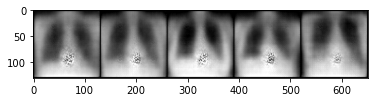

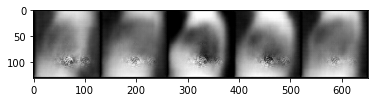

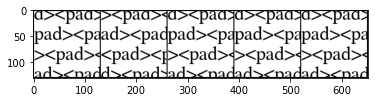

In [13]:
from matplotlib import pyplot as plt
plt.imshow(random_plots['PA'])
plt.show()
plt.imshow(random_plots['Lateral'])
plt.show()
plt.imshow(random_plots['text'])
plt.show()

# Test of the latent representations of the MMVAE
### Average precision scores on the latent representations, averaged over the batches

In [14]:
config_path = get_config_path()
with open(config_path, 'rt') as json_file:
    config = json.load(json_file)

checkpoint_path = os.path.expanduser(config['dir_fid'])
lr_evals = dict()
for modality_method in ['moe']:
    for factorization in os.listdir(os.path.join(checkpoint_path, modality_method)):
        for experiment in os.listdir(os.path.join(checkpoint_path, modality_method, factorization)):
            if experiment.startswith('Mimic'):
                lr_evals[experiment] = dict()
                lr_eval = lr_evals[experiment]
                experiment_dir_ = os.path.join(checkpoint_path, modality_method, factorization, experiment)
                lr_eval_dir = os.path.join(experiment_dir_, 'logs', 'Latent Representation')
                if os.path.exists(lr_eval_dir):
                    for label in os.listdir(lr_eval_dir):
                        lr_eval[label] = dict()
                        for lr in os.listdir(os.path.join(lr_eval_dir, label)):
                            lr_eval[label][lr] = dict()
                            for logfile in os.listdir(os.path.join(lr_eval_dir, label, lr)):
                                for summary in summary_iterator(os.path.join(lr_eval_dir, label, lr, logfile)):
                                    value = summary.summary.value
                                    temp = str(value).split('\n')
                                    for elem in temp:
                                        elem = elem
                                        if elem.startswith('simple_value'):
                                            lr_eval[label][lr][summary.step] = elem.split(' ')[1]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [15]:
import pandas as pd
experiments_dataframe = pd.read_csv('experiments_dataframe.csv')
dfs = []
for experiment in lr_evals.keys():
    experiment_evals = lr_evals[experiment]
    if experiment_evals:
        for label in experiment_evals.keys():
            for lr in experiment_evals[label].keys():
                steps = experiment_evals[label][lr].keys()
                max_step = max(steps)
                experiment_evals[label][lr] = experiment_evals[label][lr][max_step]

        df = pd.DataFrame(experiment_evals).astype(float)
        index = df.index
        index.name = f'Steps: {max_step}'
        df['mean'] = df.mean(numeric_only=True, axis=1)
        dfs.append((df, experiment))

In [16]:
for df, experiment in dfs:
    flags = experiments_dataframe.loc[experiments_dataframe['experiment_uid'] == experiment]

    print(f'Experiment {experiment} with text encoding: {flags.text_encoding.item()}, '
          f'image size: {flags.img_size.item()}, method: {flags.method.item()} \n and trained '
          f'for {flags.total_epochs.item()} epochs with batch size: {flags.batch_size.item()} '
          f'and {flags.steps_per_training_epoch.item()} steps per training epoch')
    display(df)

Experiment Mimic_2020_10_30_17_20_31_531755 with text encoding: word, image size: 128.0, method: joint_elbo 
 and trained for 18.0 epochs with batch size: 180.0 and 200.0 steps per training epoch


,Pleural Effusion,Support Devices,Lung Opacity,mean
Steps: 4060,,,,
PA_text,0.063194,0.025,0.131944,0.073380
Lateral_PA_text,0.130208,0.025,0.112831,0.089346
PA,0.059722,0.025,0.115278,0.066667
text,0.055556,0.025,0.155556,0.078704
Lateral_text,0.161111,0.025,0.116667,0.100926
Lateral_PA,0.095833,0.025,0.108796,0.076543
Lateral,0.126389,0.025,0.105556,0.085648


Experiment Mimic_2020_10_26_23_01_20_004865 with text encoding: word, image size: 128.0, method: jsd 
 and trained for 15.0 epochs with batch size: 180.0 and -1.0 steps per training epoch


,Pleural Effusion,Support Devices,Lung Opacity,mean
Steps: 6740,,,,
PA_text,0.165385,0.019444,0.112879,0.099236
Lateral_PA_text,0.210279,0.019444,0.111111,0.113612
PA,0.093269,0.019444,0.114646,0.075787
text,0.058333,0.019444,0.133333,0.070370
Lateral_text,0.129701,0.019444,0.111111,0.086752
Lateral_PA,0.099451,0.019444,0.123232,0.080709
Lateral,0.104060,0.019444,0.186111,0.103205


Experiment Mimic_2020_10_27_14_47_11_079212 with text encoding: char, image size: 128.0, method: jsd 
 and trained for 99.0 epochs with batch size: 180.0 and 100.0 steps per training epoch


,Pleural Effusion,Support Devices,Lung Opacity,mean
Steps: 10300,,,,
PA_text,0.102381,0.027778,0.131647,0.087269
Lateral_PA_text,0.069444,0.027778,0.129117,0.075446
PA,0.069444,0.027778,0.115625,0.070949
text,0.069444,0.027778,0.112401,0.069874
Lateral_text,0.069444,0.027778,0.131250,0.076157
Lateral_PA,0.069444,0.027778,0.102778,0.066667
Lateral,0.069444,0.027778,0.102778,0.066667


Experiment Mimic_2020_10_23_13_17_46_515651 with text encoding: char, image size: 128.0, method: joint_elbo 
 and trained for 299.0 epochs with batch size: 256.0 and -1.0 steps per training epoch


,Pleural Effusion,Support Devices,Lung Opacity,mean
Steps: 71100,,,,
PA_text,0.054688,0.027344,0.154948,0.078993
Lateral_PA_text,0.172519,0.027344,0.158118,0.119327
PA,0.056276,0.027344,0.127363,0.070328
text,0.122210,0.027344,0.119420,0.089658
Lateral_text,0.114397,0.027344,0.182021,0.107921
Lateral_PA,0.062686,0.027344,0.126877,0.072302
Lateral,0.060985,0.027344,0.153607,0.080645


 # Evaluation of the classifiers
 All classifiers were trained for 100 epochs

In [17]:
labels = ['Lung Opacity', 'Pleural Effusion', 'Support Devices']

FLAGS.num_features = len(alphabet)
FLAGS.batch_size = 300


## Evaluation of the character encoding and image size 128

In [18]:
list_precision_pa, list_precision_lat, list_precision_text = test_clfs(FLAGS, 128, 'char', alphabet)

print('mean precision for pa classifier: ', np.mean(list_precision_pa))
print('mean precision for lat classifier: ',np.mean(list_precision_lat))
print('mean precision for text classifier: ',np.mean(list_precision_text))

setting dataset
setting modalities
setting model
setting clfs
setting rec_weights
dict_keys(['real', 'random', '', 'PA', 'Lateral', 'text', 'Lateral_PA', 'PA_text', 'Lateral_text', 'Lateral_PA_text'])
char
mean precision for pa classifier:  0.39415439014746345
mean precision for lat classifier:  0.23401534481353384
mean precision for text classifier:  0.5803474159536921


## Evaluation of the word encoding and image size 128
### The text classifier precision is slightly better for the word encoding

In [19]:
list_precision_pa, list_precision_lat,list_precision_text = test_clfs(FLAGS, 128, 'word', alphabet)
print('mean precision for pa classifier: ',np.mean(list_precision_pa))
print('mean precision for lat classifier: ',np.mean(list_precision_lat))
print('mean precision for text classifier: ',np.mean(list_precision_text))

setting dataset
setting modalities
setting model
setting clfs
setting rec_weights
dict_keys(['real', 'random', '', 'PA', 'Lateral', 'text', 'Lateral_PA', 'PA_text', 'Lateral_text', 'Lateral_PA_text'])
word
mean precision for pa classifier:  0.36514591827396703
mean precision for lat classifier:  0.2211051543545864
mean precision for text classifier:  0.674078788856655


## Evaluation of image size 256
Loading the 256 dataset crashes jupyter notebooks for some reason. If that's the case, run it from the command
line with: `jupyter nbconvert --to notebook --execute notebooks/model_exploration.ipynb`

In [20]:
import numpy as np

from mimic.dataio.MimicDataset import Mimic
from mimic.utils.experiment import MimicExperiment
FLAGS.text_encoding = 'char'
FLAGS.img_size = 256
mimic_experiment = MimicExperiment(flags=FLAGS, alphabet=alphabet)
mimic_test = Mimic(FLAGS, mimic_experiment.labels, alphabet, split='test')
model_text = mimic_experiment.clfs['text']

setting dataset
setting modalities
setting model
setting clfs
setting rec_weights
dict_keys(['real', 'random', '', 'PA', 'Lateral', 'text', 'Lateral_PA', 'PA_text', 'Lateral_text', 'Lateral_PA_text'])


In [21]:
list_precision_pa = test_clf_pa(FLAGS, mimic_experiment, mimic_test, alphabet)
list_precision_lat = test_clf_lat(FLAGS, mimic_experiment, mimic_test, alphabet)
list_precision_text = test_clf_text(FLAGS, mimic_experiment, mimic_test, alphabet)
print('mean precision for pa classifier: ',np.mean(list_precision_pa))
print('mean precision for lat classifier: ',np.mean(list_precision_lat))
print('mean precision for text classifier: ',np.mean(list_precision_text))


char
char
char
mean precision for pa classifier:  0.41602969689539815
mean precision for lat classifier:  0.40079714910746855
mean precision for text classifier:  0.5953110664731457
